## Imports

In [1]:
import sys
import numpy as np
import pandas as pd
from os.path import abspath, join as opj
from scipy.spatial.distance import cdist
from scipy.stats import sem
from tqdm.notebook import tqdm, trange

sys.path.insert(0, abspath('../helpers/'))
from participant import Participant
from experiment import Experiment

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

## Set paths and params

In [2]:
raw_path = '../../data/raw/psiturk-data-raw.tsv'
figdir = '../../paper/figs/'
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('hls')
plt.rcParams['pdf.fonttype'] = 42
cp, c3, c2, c1 = sns.color_palette()[:4]

## Define plotting function

In [3]:
def bootstrap_ci(M, ci=95, n_boots=1000, color='#1f77b4', alpha=0.3, return_bounds=False, label=None, ax=None):
    x_data = np.arange(M.shape[0])
    y = M.mean(axis=1)
    ci_low = (100 - ci) / 2
    ci_high = 100 - ci_low
    L, U = np.empty(x_data.shape), np.empty(x_data.shape)
  # constructs a single resample
    boot_mean = lambda x: np.random.choice(x, size=len(x), replace=True).mean()
    for x_val in x_data:
        x_dists = M[x_val]
        boot_iter = (boot_mean(x_dists) for n in range(n_boots))
        boots = np.fromiter(boot_iter, dtype=float)
        # use percentile bootstrap (seaborn default method)
        L[x_val], U[x_val] = np.percentile(boots, ci_low), np.percentile(boots, ci_high)
    if ax is not None:
        # error ribbons
        ax.fill_between(x_data, L, U, color=color, alpha=alpha)
        # opaque line
        ax.plot(x_data, y, color=color, label=label)
        returns = []
    else:
        h1 = plt.fill_between(x_data, L, U, color=color, alpha=alpha)
        h2 = plt.plot(x_data, y, color=color, label=label)
        returns = [h1, h2]
    if return_bounds:
        returns.extend([L, U])
    return returns

## Load data

In [4]:
exp = Experiment()
exp.load_questions()
exp.load_lecture_trajs()
exp.load_question_vectors()

In [5]:
raw_path = '../../data/raw/psiturk-data-raw.tsv'
raw_data = pd.read_csv(raw_path, sep='\t', index_col='Unnamed: 0')
raw_data.head()

,uniqueid,assignmentid,workerid,hitid,ipaddress,browser,platform,language,cond,counterbalance,codeversion,beginhit,beginexp,endhit,bonus,status,mode,datastring
0,debuga32joxa6zu7q0y:debug3aqf3rz55aocyv9v9oc6r...,3AQF3RZ55AOCYV9V9OC6RCXJB5FF69,A32JOXA6ZU7Q0Y,33K3E8REWX1EFBLACVAPTDY1FXBX8T,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-26 17:47:30,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
1,debuga32joxa6zu7q0y:debug304sm51wa5ar8cvcbztd9...,304SM51WA5AR8CVCBZTD9R2QEXQSBY,A32JOXA6ZU7Q0Y,391FPZIE4DSFRIS8AUT8MJSWOZUHUC,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-29 18:43:33,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
2,debuga32joxa6zu7q0y:debug3aqf3rz55aocyv9v9oc6r...,3AQF3RZ55AOCYV9V9OC6RCXJB6M6F9,A32JOXA6ZU7Q0Y,31MBOZ6PAPXLRKUYFON6K5ZXYGXCL5,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-29 19:29:40,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
3,debugdebugwzop7d:debugdebug4j19zm,3OE22WJIGKUURVP5JML3JHFDLUOUQ4,A32JOXA6ZU7Q0Y,3P520RYKCIC3BP8D9SSZXMP6JRR5U9,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-05-01 19:34:15,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
4,debuga32joxa6zu7q0y:debug3dzqrbdbsnlm5hrzw6e7r...,3DZQRBDBSNLM5HRZW6E7R84EQ50S3U,A32JOXA6ZU7Q0Y,36FFXPMSTAUKED8BE8HZND076EHHOC,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-05-03 17:54:55,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."


## Create Participant objects

In [6]:
participants = []
for ix, row in tqdm(raw_data.iterrows(), total=raw_data.shape[0], leave=False):
    p = Participant.from_psiturk(row, subid=f'P{ix + 1}')
    participants.append(p)

In [7]:
participants[0].head()

Participant P1


,qID,accuracy,qset,lecture
0,13,1,0,1
1,21,0,0,2
2,12,0,0,1
3,16,1,0,2
4,28,1,0,2


## Reconstruct memory traces for each set of quiz questions, for each lecture

In [8]:
# Participant object to store across-participant avgerages
avg_participant = Participant('avg')

traces = {}
for lecture in ['forces', 'bos']:
    trace_arr = np.empty((3, 50, exp.get_lecture_traj(lecture).shape[0]), dtype=np.float64)
    for qset in range(3):
        store_key = f'{lecture}_qset{qset}'
        for i, p in enumerate(tqdm(participants, desc=f'{lecture}, {qset+1}/3', leave=False)):
            # reconstruct trace for single participant/lecture/question set, store in Participant object
            trace_arr[qset, i] = p.reconstruct_trace(exp, lecture=lecture, qset=qset, store=store_key)
        # store average in avg participant object
        avg_participant.store_trace(trace_arr[qset].mean(axis=0), store_key)
    traces[lecture] = trace_arr
exp.participants = participants
exp.avg_participant = avg_participant

## Save Participant objects with reconstructed traces

In [9]:
for p in participants:
    p.save()
avg_participant.save()

## Plot model-derived content mastery

In [10]:
ff_traces = np.swapaxes(traces['forces'], 1, 2)
bos_traces = np.swapaxes(traces['bos'], 1, 2)

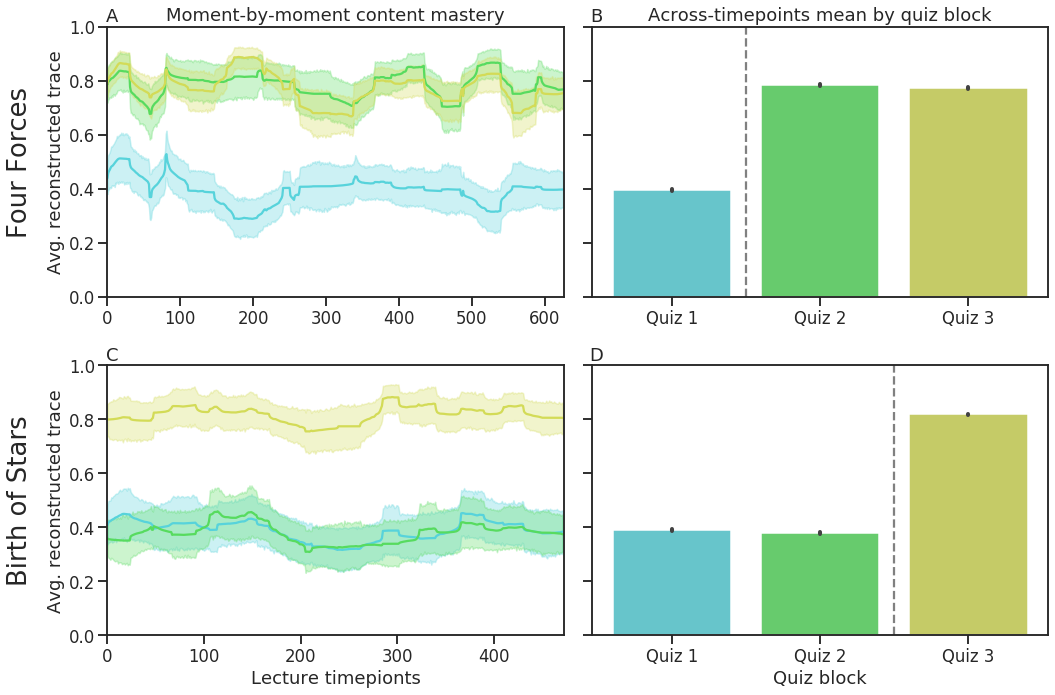

In [11]:
fig, axarr = plt.subplots(2, 2, sharey=True)
fig.set_size_inches(15, 10)
((a, b),
 (c, d)) = axarr

bootstrap_ci(ff_traces[0], color=c1, ax=a)
bootstrap_ci(ff_traces[1], color=c2, ax=a)
bootstrap_ci(ff_traces[2], color=c3, ax=a)
a.set_ylim(0, 1)
a.set_xlim(0, ff_traces[0].shape[0])
a.set_ylabel('Avg. reconstructed trace')
a.set_title('Moment-by-moment content mastery')
a.annotate('Four Forces', xy=(-.75, .5), xycoords=a.yaxis.label, size='x-large', 
           rotation=90, ha='right', va='center')

sns.barplot(data=np.split(ff_traces, 3), palette=[c1, c2, c3], ax=b)
b.set_xticklabels(['Quiz 1', 'Quiz 2', 'Quiz 3'])
b.vlines(x=.5, ymin=0, ymax=1, linestyles='dashed', colors='gray')
b.set_ylim(0, 1)
b.set_title('Across-timepoints mean by quiz block')

bootstrap_ci(bos_traces[0], color=c1, ax=c)
bootstrap_ci(bos_traces[1], color=c2, ax=c)
bootstrap_ci(bos_traces[2], color=c3, ax=c)
c.set_ylim(0, 1)
c.set_xlim(0, bos_traces[0].shape[0])
c.set_xlabel('Lecture timepionts')
c.set_ylabel('Avg. reconstructed trace')
c.annotate('Birth of Stars', xy=(-.75, .5), xycoords=c.yaxis.label, size='x-large', 
           rotation=90, ha='right', va='center')

sns.barplot(data=np.split(bos_traces, 3), palette=[c1, c2, c3], ax=d)
d.set_xticklabels(['Quiz 1', 'Quiz 2', 'Quiz 3'])
d.vlines(x=1.5, ymin=0, ymax=1, linestyles='dashed', colors='gray')
d.set_ylim(0, 1)
d.set_xlabel('Quiz block')

labels = 'ABCD'
for i, ax in enumerate((a, b, c, d)):
    ax.text(0.01, 1.02, labels[i], horizontalalignment='center', 
            transform=ax.transAxes, fontsize=18)

plt.tight_layout()
# plt.savefig(opj(figdir, 'content-mastery.pdf'), bbox_inches='tight')
plt.show()